# Using Giovanni to Compute and Plot Anomalies
***

### This feature would allow users who are interested in studying a particular event. For example, upper air weather events such as an Omega Block or climatological phenomena like El Nino are best observed from the anomaly field. 

### Many of Giovanni's datasets have matured to a stage where we can more confidently compute a climatology of different variables. 

### The following example shows a practical example using 30 years of Monthly MERRA-2 500 hPa heights to show an Omega Block event from May of 2025. 

***

### This notebook requires the following python packages and their dependencies installed via conda-forge. 

__Required:__
- numpy
- xarray
- matplotlib
- glob (for gathering list of .nc4 files)

___Used for Plotting (Optional):___
- cmaps (NCL Colormaps)
- cartopy
- mpl_toolkits.axes_grid1.inset_locator

#### GES DISC Data Used in Example 

In this example we use 30 Years of Monthly MERRA-2 500 hPa heights downloaded using from the [M2TMNXSLV_5.12.4 dataset](https://disc.gsfc.nasa.gov/datasets/M2TMNXSLV_5.12.4/summary) and [MERRA-2 3-hr Time Averaged 500 hPa from Giovanni](https://giovanni.gsfc.nasa.gov/giovanni/#service=TmAvMp&starttime=2025-05-05T00:00:00Z&endtime=2025-08-05T23:59:59Z&bbox=-127.9687,25.1697,-66.9727,50.8337&data=M2I3NPASM_5_12_4_H(z%3D500)). 

We subset the Monthly Data by accessing the [dataset landing page](https://disc.gsfc.nasa.gov/datasets/M2TMNXSLV_5.12.4/summary) and subset via OPeNDAP using a bounding box of (-127.97,25.17,-66.97,50.83) from Giovanni, selecting the "height_at_500_hPa" variable and then download using one of the options from the [GES DISC Data Access FAQ](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Access%20GES%20DISC%20Data%20Using%20wget%20and%20curl). 


***

##### Importing Libraries 

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

##### Gather list of monthly data files and open in Xarray

In [2]:
#List of Monthly Files From MERRA-2 (1995-2024)
M2_Mon_files = glob.glob('C:/Users/bomitch1/Downloads/Data-In-Action May Omega Block/MERRA-2_500hPa/Monthly_500hPa_MERRA-2_h/M2TMNXSLV*.nc4')

#Opening as one Dataset in Xarray
M2_M_500hPa_H = xr.open_mfdataset(M2_Mon_files)['H500']
print(M2_M_500hPa_H)

#Time Averaged MERRA-2 3-hr 500 hPa heights from Giovanni
May_Omega = xr.open_dataset('C:/Users/bomitch1/Downloads/Data-In-Action May Omega Block/Extra/g4.timeAvgMap.M2I3NPASM_5_12_4_H.500hPa.20250505-20250505.127W_25N_66W_50N.nc')['M2I3NPASM_5_12_4_H']
print(May_Omega)

<xarray.DataArray 'H500' (time: 360, lat: 53, lon: 99)> Size: 8MB
dask.array<concatenate, shape=(360, 53, 99), dtype=float32, chunksize=(1, 53, 99), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 792B -128.1 -127.5 -126.9 ... -68.12 -67.5 -66.88
  * time     (time) datetime64[ns] 3kB 1994-05-01T00:30:00 ... 2024-05-01T00:...
  * lat      (lat) float64 424B 25.0 25.5 26.0 26.5 27.0 ... 49.5 50.0 50.5 51.0
Attributes:
    long_name:       height_at_500_hPa
    units:           m
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]
<xarray.DataArray 'M2I3NPASM_5_12_4_H' (lat: 51, lon: 97)> Size: 20kB
[4947 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 408B 25.5 26.0 26.5 27.0 27.5 ... 49.0 49.5 50.0 50.5
  * lon      (lon) float64 776B -127.5 -126.9 -126.2 ... -68.75 -68.12 -67.5
Attributes: (12/14)
    units:                 m
    fmissing_valu

##### Since our Omega Block occured in May, subsetting the dataset to compute the anomaly for May 500 hPa Geopotential Heights is appropriate. 

In [3]:
#Subset the Large Dataset 
May_500 = M2_M_500hPa_H.sel(time=M2_M_500hPa_H['time.month'] ==5)[1:31]
print(May_500)

#Take the mean across the time dimension (this does the 30 year mean at each grid cell)
May_500_mean = May_500.mean(dim='time')

#We can also take the standard deviation if we wanted to compute Standardized Anomalies
May_500_std = May_500.std(dim='time')

<xarray.DataArray 'H500' (time: 30, lat: 53, lon: 99)> Size: 630kB
dask.array<getitem, shape=(30, 53, 99), dtype=float32, chunksize=(1, 53, 99), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 792B -128.1 -127.5 -126.9 ... -68.12 -67.5 -66.88
  * time     (time) datetime64[ns] 240B 1995-05-01T00:30:00 ... 2024-05-01T00...
  * lat      (lat) float64 424B 25.0 25.5 26.0 26.5 27.0 ... 49.5 50.0 50.5 51.0
Attributes:
    long_name:       height_at_500_hPa
    units:           m
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]


##### The Anomaly is computed as our event minus the climatology (or 30 year mean)

In [4]:
Anom = May_Omega - May_500_mean

#If we divide by the 30-yr standard deviation we can compute the Standardized Anomaly which
#shows us the deviation from normal in terms of standard deviations instead of raw values.
#This is good for variables such as temperature where some places normally experience large variations
#so a large temperature swing may not mean the same thing or have the same impact in different locations.
Std_Anom = Anom/May_500_std

##### Plotting the 30-yr May MERRA-2 500 hPa Geopotential Height Climatological Mean

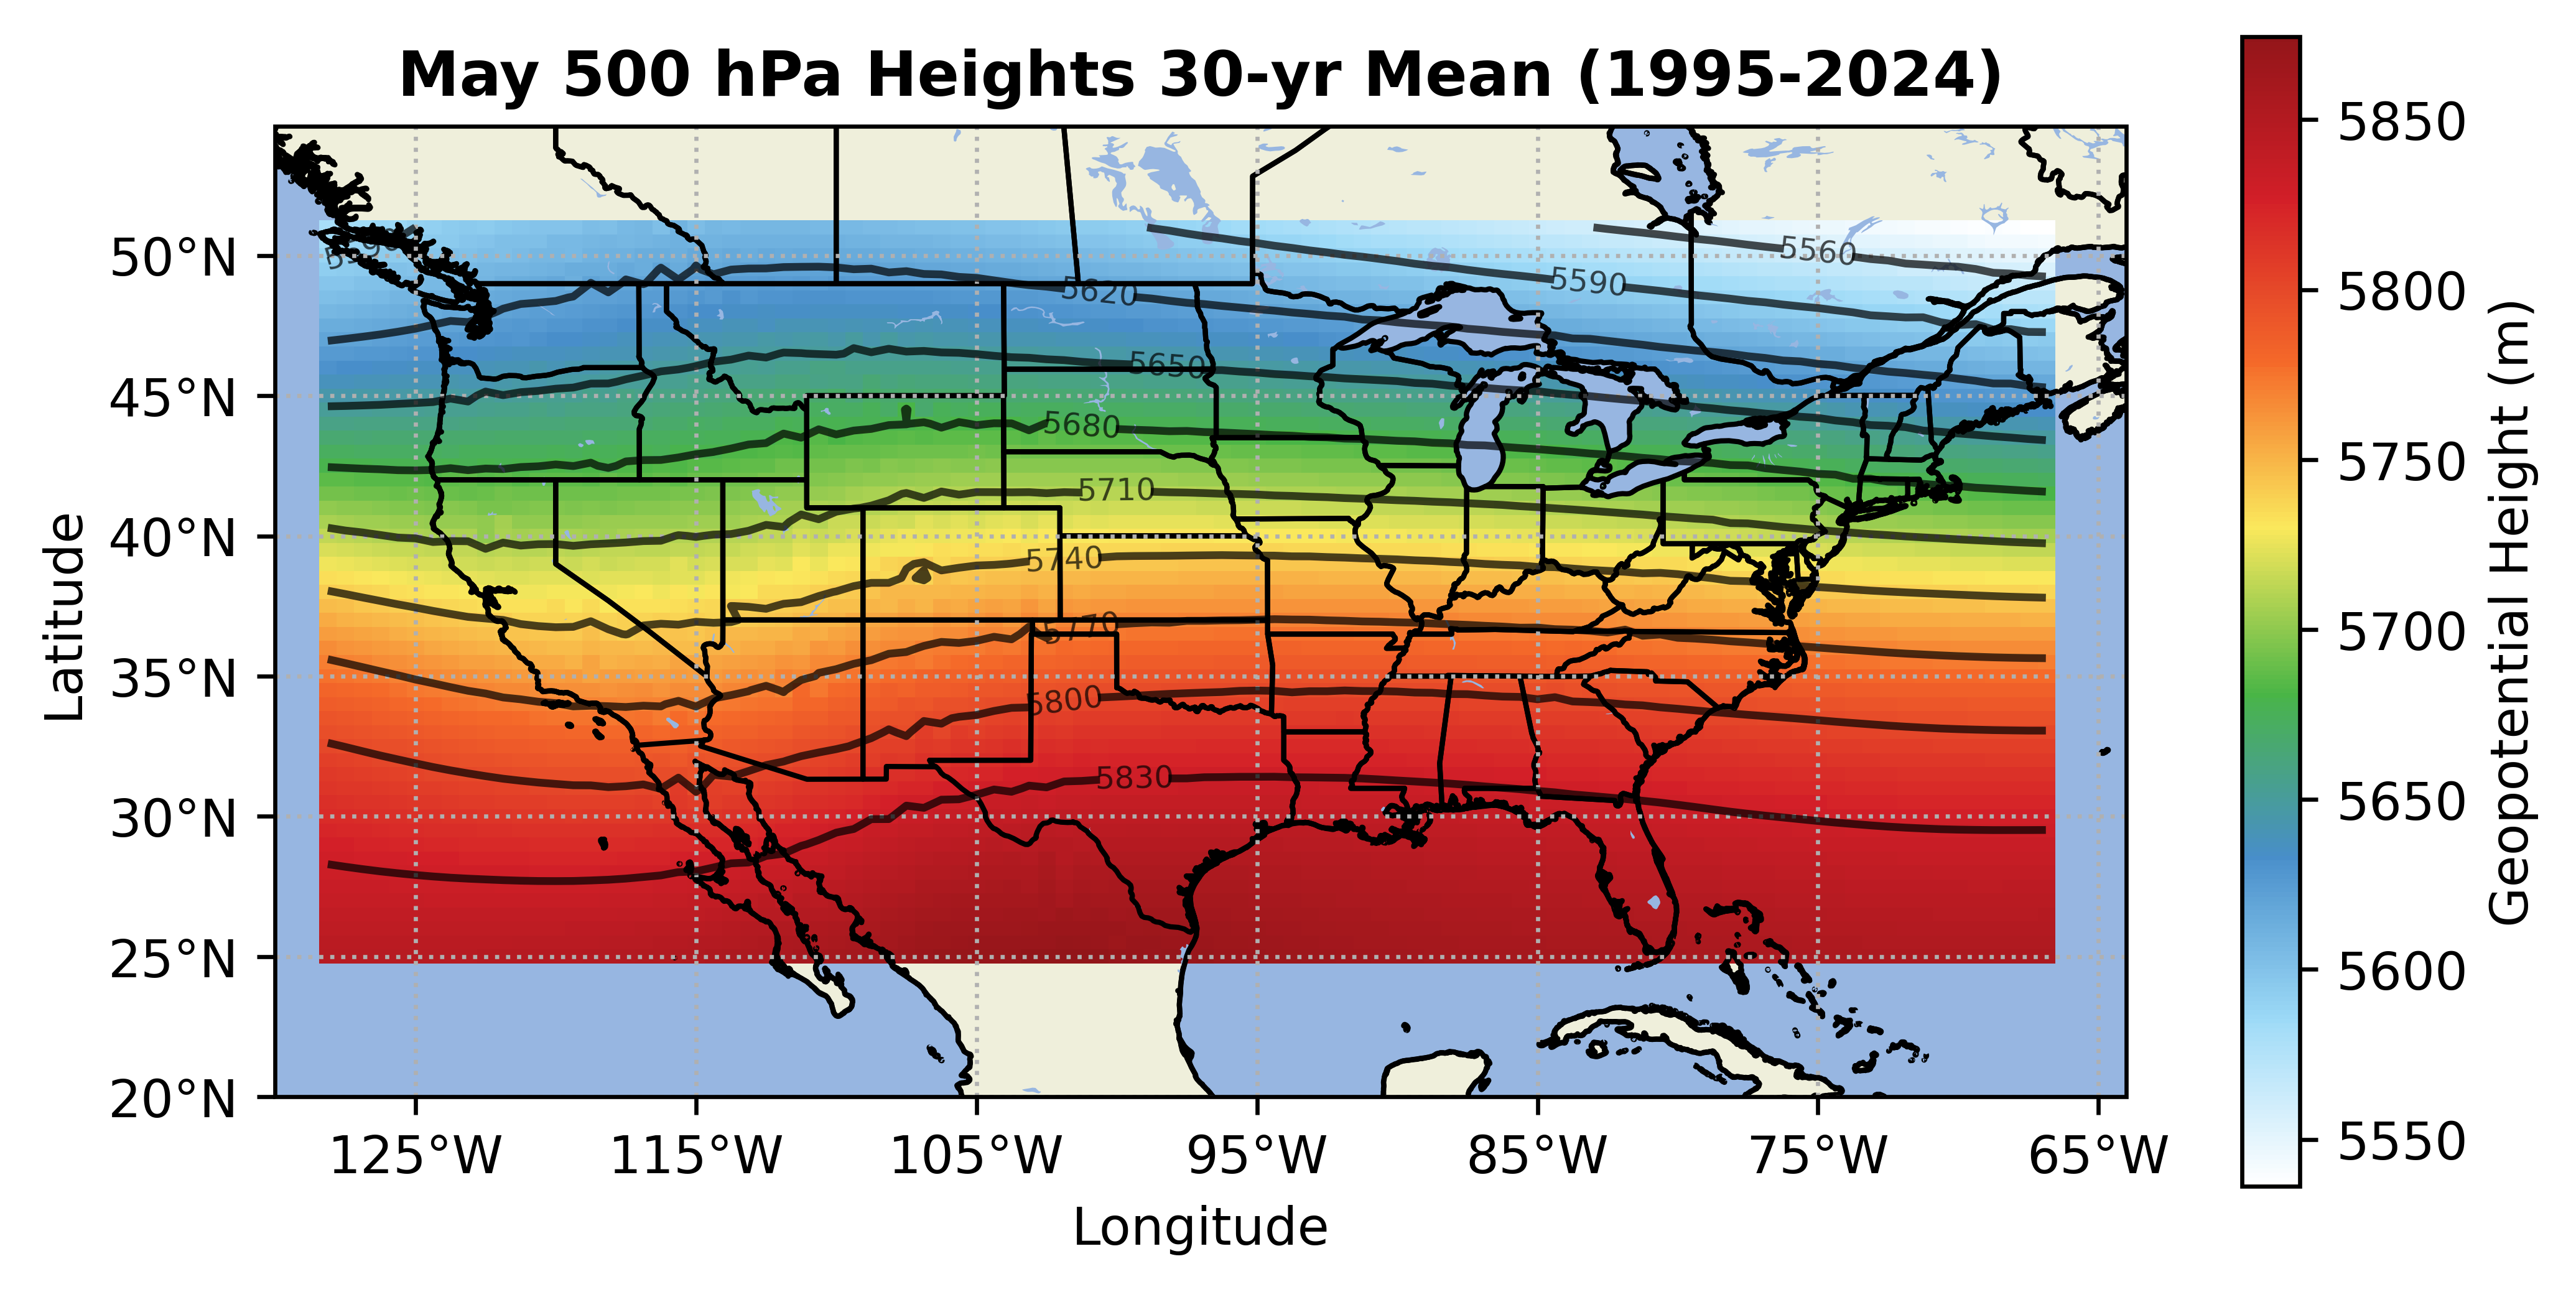

In [5]:
#Generate Figure and Draw Axes using Cartopy Plate Carree Projection 
fig, ax1 = plt.subplots(1,1,figsize=(8,4),subplot_kw={"projection": ccrs.PlateCarree()},
                          dpi=600)
ax1 = plt.subplot(1,1,1)

#Set Map Extent
ax1.set_extent([-130, -64, 20, 50])

#Add Map Features
ax1.coastlines(resolution='10m')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.LAKES)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES, edgecolor='black')
ax1.grid(linestyle='dotted')

#Create and Format Ticks
ax1.set_yticks(np.arange(20,51,5), crs=ccrs.PlateCarree())
ax1.set_xticks(np.arange(-125,-64,10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

#Plot Values on the Map
grid = May_500_mean.plot.imshow(ax=ax1,cmap=cmaps.WhiteBlueGreenYellowRed,add_colorbar=False)

#Add Contours to Map (to illustrate the height field)
contour_500h = May_500_mean.plot.contour(vmin=5500,vmax=5830,levels=12,colors='k',
                                 add_labels=True,ax=ax1,alpha=0.7)
ax1.clabel(contour_500h, fontsize=6)

#Add our own Colorbar 
cb = plt.colorbar(grid, ax=ax1, orientation = 'vertical', label='Geopotential Height (m)')

#Add the Plot Title and X and Y axis labels along with font sizes
ax1.set_title('May 500 hPa Heights 30-yr Mean (1995-2024)', size=12, fontweight='bold')
ax1.set_xlabel("Longitude",  size=10)
ax1.set_ylabel("Latitude", size=10)
ax1.tick_params(axis='x', labelsize=10)  
ax1.tick_params(axis='y', labelsize=10) 

##### Plotting the MERRA-2 Height Field Anomaly for the May Omega Block Event 

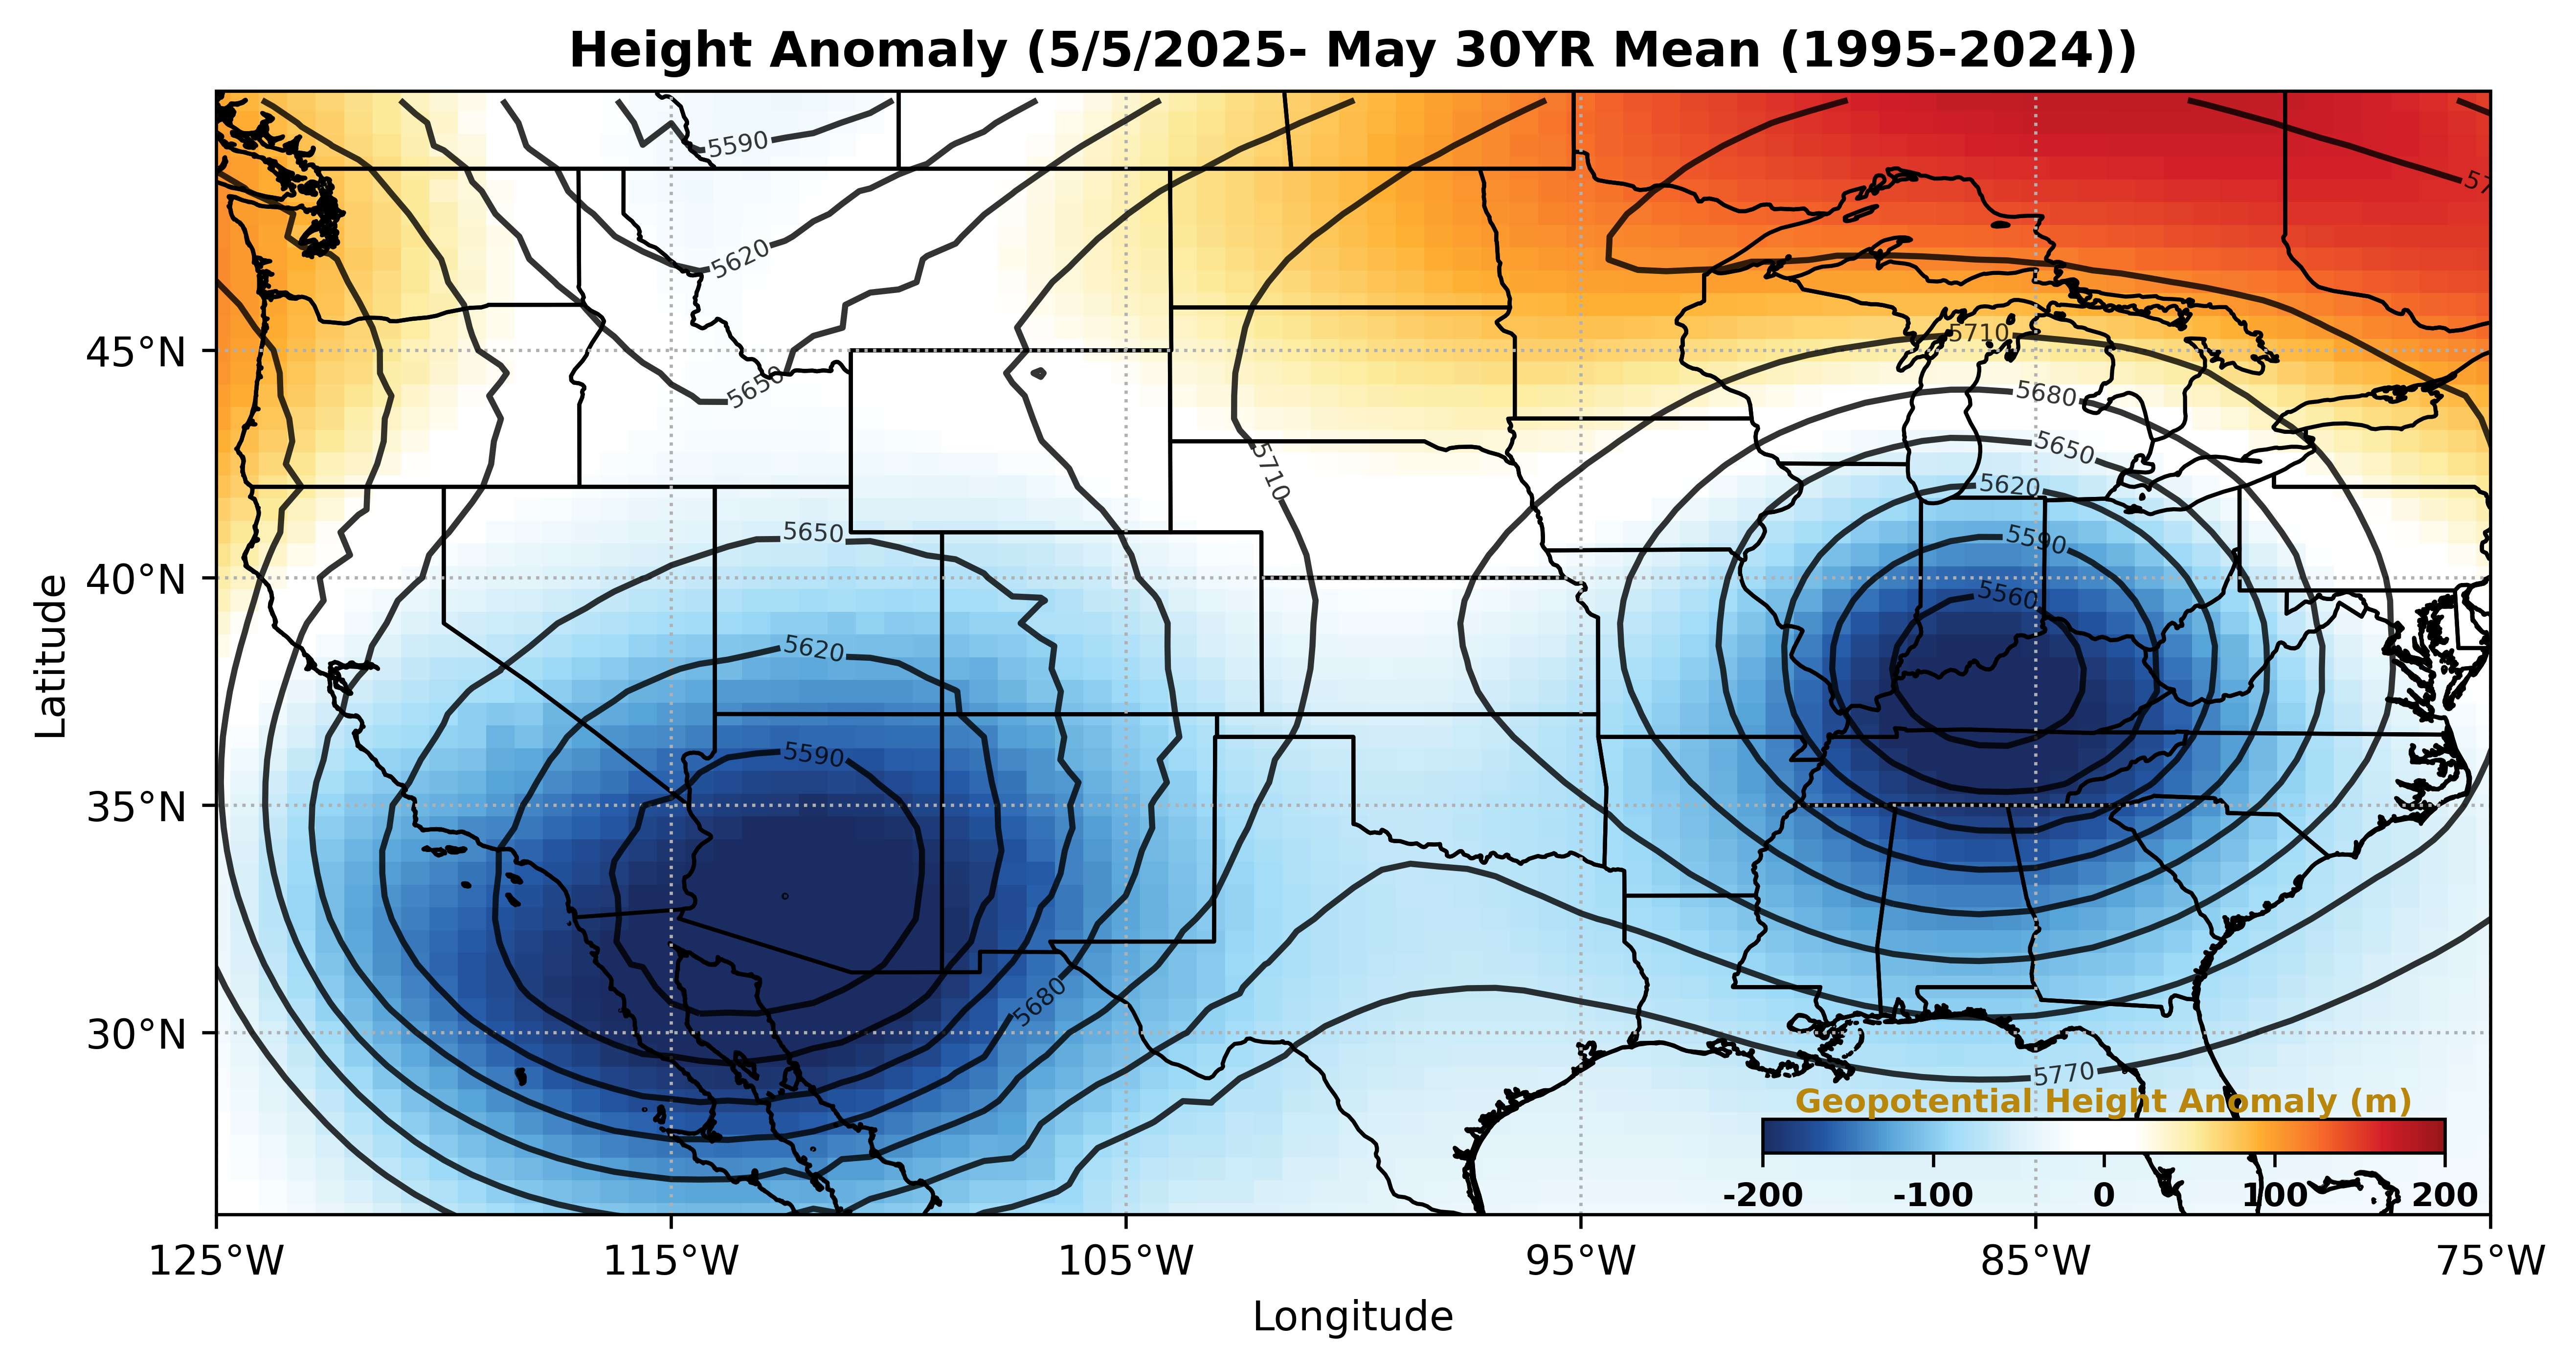

In [6]:
#Generate Figure and Draw Axes using Cartopy Plate Carree Projection
fig, ax1 = plt.subplots(1,1,figsize=(10,6),subplot_kw={"projection": ccrs.PlateCarree()},
                          dpi=600)
ax1 = plt.subplot(1,1,1)

#Set Map Extent
ax1.set_extent([-125, -75, 26, 48])

#Adding Map Features
ax1.coastlines(resolution='10m')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE,alpha=0.7)
ax1.add_feature(cfeature.STATES, edgecolor='black')

#Create and Format Ticks
ax1.set_yticks(np.arange(30,46,5), crs=ccrs.PlateCarree())
ax1.set_xticks(np.arange(-125,-74,10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.grid(linestyle='dotted')

#Add Contours to Map (to illustrate the height field)
contour = May_Omega.plot.contour(vmin=5500,vmax=5770,levels=10,colors='k',
                                 add_labels=True,ax=ax1,alpha=0.8)
ax1.clabel(contour, fontsize=6)

#Plot Anomaly Values on the Map
grid = Anom.plot.imshow(ax=ax1,cmap=cmaps.BlueWhiteOrangeRed,add_colorbar=False,vmin=-200,vmax=200)

#Inset the Colorbar to the bottom right of the figure
cbaxes = ax1.inset_axes([0.68, 0.055, 0.3, 0.03]) 
cb = plt.colorbar(grid, cax=cbaxes, orientation = 'horizontal')
cb.ax.set_xticks(np.arange(-200,201,100))
cb.ax.set_xticklabels(labels=np.arange(-200,201,100),size=8,weight='bold')
cb.ax.set_facecolor('black')
cb.ax.set_title('Geopotential Height Anomaly (m)', size=8, weight='bold',pad=0.01,color='darkgoldenrod') 

#Add the Plot Title and X and Y axis labels along with font sizes
ax1.set_title('Height Anomaly (5/5/2025 - May 30YR Mean (1995-2024))', size=12, fontweight='bold')
ax1.set_xlabel("Longitude",  size=10)
ax1.set_ylabel("Latitude", size=10)
ax1.tick_params(axis='x', labelsize=10)  
ax1.tick_params(axis='y', labelsize=10) 